## Predikcia vsetkych parametrov pomocou jednej NN pre detached data

In [1]:
# LIBRARIES
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from keras.utils import np_utils
from keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D, SpatialDropout1D, GlobalAveragePooling1D
from keras.layers import Input, Dense, concatenate, Activation, LSTM, Dropout, Flatten
from keras.models import Model
from keras.layers.merge import Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [3]:
np.random.seed(1234)
pd.set_option('display.max_rows', None)

In [4]:
def generate_observation_sigma(space_obs_frac=0.5):
    """
    Draws a standard deviation of noise in light curve points from a "true" value provided in synthetic light curve.
    Noise sigma is drawn from bimodal distribution taking into account contributions from space based and earth based
    observations which have different levels of stochastic noise.

    :param space_obs_frac: ratio between earth based and space based observations
    :return: float; standard deviation of the light curve noise
    """
    earth_based_sigma = 4e-3
    space_based_sigma = 2e-4
    sigma = np.random.choice([earth_based_sigma, space_based_sigma], p=[1-space_obs_frac, space_obs_frac])
    return np.random.rayleigh(sigma)

def stochastic_noise_generator(curve):
    """
    Introduces gaussian noise into synthetic observation provided in `curve`.

    :param curve: numpy.array; normalized light curve
    :return: Tuple(numpy.array, float); normalized light curve with added noise, standard deviation of observations
    """
    sigma = generate_observation_sigma()
    return np.random.normal(curve, sigma), np.full(curve.shape, sigma)

### Data loading

In [5]:
data = pd.read_pickle("detached_all_parameters.pkl").reset_index()

In [6]:
data.head()

,index,id,curve,primary__t_eff,secondary__t_eff,inclination,mass_ratio,primary__surface_potential,secondary__surface_potential,t1_t2,filter,critical_surface_potential,primary__equivalent_radius,secondary__equivalent_radius,primary__filling_factor,secondary__filling_factor
0,0,38,"[0.6055271686415179, 0.9842041250556204, 0.999...",7000,4000,1.560796,10.0,110.00005,996.5005,1.75,Bessell_U,15.09104,0.009996,0.009996,-145.333979,-1502.830354
1,1,38,"[0.608985656265516, 0.9846965713304289, 0.9998...",7000,4000,1.560796,10.0,110.00005,996.5005,1.75,Bessell_B,15.09104,0.009996,0.009996,-145.333979,-1502.830354
2,2,38,"[0.6189025614226916, 0.9837351924934223, 0.999...",7000,4000,1.560796,10.0,110.00005,996.5005,1.75,Bessell_V,15.09104,0.009996,0.009996,-145.333979,-1502.830354
3,3,38,"[0.6292771409565273, 0.9832675811171884, 0.999...",7000,4000,1.560796,10.0,110.00005,996.5005,1.75,Bessell_R,15.09104,0.009996,0.009996,-145.333979,-1502.830354
4,4,38,"[0.6543378609145588, 0.9835188424579704, 0.999...",7000,4000,1.560796,10.0,110.00005,996.5005,1.75,Bessell_I,15.09104,0.009996,0.009996,-145.333979,-1502.830354


In [6]:
data_sample = data.sample(n=100000)

In [7]:
list(data_sample.columns)

['index',
 'id',
 'curve',
 'primary__t_eff',
 'secondary__t_eff',
 'inclination',
 'mass_ratio',
 'primary__surface_potential',
 'secondary__surface_potential',
 't1_t2',
 'filter',
 'critical_surface_potential',
 'primary__equivalent_radius',
 'secondary__equivalent_radius',
 'primary__filling_factor',
 'secondary__filling_factor']

### Train-test split

In [8]:
X = []
for row in data_sample["curve"]:
    X.append(row)
X = np.array(X)

In [9]:
X.shape

(100000, 400)

In [9]:
y = np.array(data_sample[[
    # "primary__t_eff",
    # "secondary__t_eff",
    "inclination",
    "mass_ratio",
    "primary__surface_potential",
    "secondary__surface_potential",
    "t1_t2",
    "critical_surface_potential",
    "primary__equivalent_radius",
    "secondary__equivalent_radius",
    "primary__filling_factor",
    "secondary__filling_factor"]])

In [10]:
X_train1, X_test, y_train1, y_test = train_test_split(X, y, test_size=0.2)

In [11]:
X_train = []
y_train = []
for i in range(len(X_train1)):
    for j in range(3):
        curve = stochastic_noise_generator(X_train1[i])
        X_train.append(curve[0])
        y_train.append(y_train1[i])
X_train = np.array(X_train)
y_train=np.array(y_train)

In [12]:
print("Number of records in dataset: ", len(data),
    "\nNumber of records in sample: ", len(X),
    "\nNumber of train data without noise: ", len(X_train1),
    "\nNumber of train data with noise: ", len(X_train),
    "\nNumber of test data without noise: ", len(X_test))

Number of records in dataset:  1300000 
Number of records in sample:  100000 
Number of train data without noise:  80000 
Number of train data with noise:  240000 
Number of test data without noise:  20000


### Model

In [13]:
inputs = Input(shape=(400, 1))
b = Conv1D(64, kernel_size = 3, padding = "valid")(inputs)
b = MaxPooling1D(2)(b)
b = Dropout(0.2)(b)
b = LSTM(64, return_sequences=True)(b)
b = Flatten()(b)
b = Dense(64, activation='relu')(b)
x = Dense(32, activation='relu')(b)
output = Dense(10, activation='linear')(x)
model = Model(inputs=inputs, outputs=output)
model.compile(loss='mse', optimizer='adam', metrics=["mae", "mape"])
print(model.summary())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 400, 1)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 398, 64)           256       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 199, 64)           0         
_________________________________________________________________
dropout (Dropout)            (None, 199, 64)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 199, 64)           33024     
_________________________________________________________________
flatten (Flatten)            (None, 12736)             0         
_________________________________________________________________
dense (Dense)                (None, 64)               

In [14]:
saved_model = "models/detached_allParams.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor = 'val_mae', verbose = 1, save_best_only = True, mode = 'min')
early = EarlyStopping(monitor = "val_mae", mode = "min", patience = 25)
callbacks_list = [checkpoint, early]

In [15]:
history = model.fit(X_train, y_train, validation_split = 0.1, epochs = 10, verbose = 1, callbacks = callbacks_list, batch_size = 64)

Epoch 1/10
3375/3375 [==============================] - ETA: 0s - loss: 1328.0272 - mae: 9.6728 - mape: 3432.2437
Epoch 00001: val_mae improved from inf to 8.66192, saving model to models\detached_allParams.hdf5
3375/3375 [==============================] - 626s 186ms/step - loss: 1328.0272 - mae: 9.6728 - mape: 3432.2437 - val_loss: 1217.9954 - val_mae: 8.6619 - val_mape: 2219.9961
Epoch 2/10
3375/3375 [==============================] - ETA: 0s - loss: 1224.9697 - mae: 8.9784 - mape: 2610.2327 ETA: 2s - loss: 1225.5969 - mae: 
Epoch 00002: val_mae did not improve from 8.66192
3375/3375 [==============================] - 629s 186ms/step - loss: 1224.9697 - mae: 8.9784 - mape: 2610.2327 - val_loss: 1243.6257 - val_mae: 9.7287 - val_mape: 2925.8972
Epoch 3/10
3375/3375 [==============================] - ETA: 0s - loss: 1185.8466 - mae: 8.6748 - mape: 2297.4058
Epoch 00003: val_mae improved from 8.66192 to 7.64794, saving model to models\detached_allParams.hdf5
3375/3375 [=================

In [13]:
model = load_model("models/detached_allParams.hdf5")

In [19]:
#EVALUATED ON TEST DATA WITHOUT NOISE
model.evaluate(X_test, y_test)

625/625 [==============================] - 25s 41ms/step - loss: 10106683.0000 - mean_absolute_error: 962.9750 - mean_absolute_percentage_error: 5412.9590


[10106683.0, 962.9749755859375, 5412.958984375]

In [14]:
# ADD NOISE TO TEST DATA
X_test_n = []
y_test_n = []
for i in range(len(X_test)):
    for j in range(3):
        curve = stochastic_noise_generator(X_test[i])
        X_test_n.append(curve[0])
        y_test_n.append(y_test[i])
        j += 1

In [15]:
X_test_n = np.array(X_test_n)
y_test_n = np.array(y_test_n)

In [22]:
# EVALUATED ON TEST DATA WITH NOISE
model.evaluate(X_test_n, y_test_n)

1875/1875 [==============================] - 78s 42ms/step - loss: 10111531.0000 - mean_absolute_error: 963.3533 - mean_absolute_percentage_error: 5418.0361


[10111531.0, 963.3533325195312, 5418.0361328125]

### Prediction on synthetic test data - without noise

In [16]:
y_pred = model.predict(X_test)

In [18]:
# P_prim__t_eff = [i[0] for i in y_pred]
# P_sec__t_eff = [i[1] for i in y_pred]
P_inclination = [i[0] for i in y_pred]
P_mass_ratio = [i[1] for i in y_pred]
P_prim__surface_potential = [i[2] for i in y_pred]
P_sec__surface_potential = [i[3] for i in y_pred]
P_t1_t2 = [i[4] for i in y_pred]
P_critical_surface_potential = [i[5] for i in y_pred]
P_primary_equivalent_radius = [i[6] for i in y_pred]
P_secondary_equivalent_radius = [i[7] for i in y_pred]
P_primary_filling_factor = [i[8] for i in y_pred]
P_secondary_filling_factor = [i[9] for i in y_pred]

In [19]:
# P_prim__t_eff = np.reshape(P_prim__t_eff, len(P_prim__t_eff))
# P_sec__t_eff = np.reshape(P_sec__t_eff, len(P_sec__t_eff))
P_inclination = np.reshape(P_inclination, len(P_inclination))
P_mass_ratio = np.reshape(P_mass_ratio, len(P_mass_ratio))
P_prim__surface_potential = np.reshape(P_prim__surface_potential, len(P_prim__surface_potential))
P_sec__surface_potential = np.reshape(P_sec__surface_potential, len(P_sec__surface_potential))
P_t1_t2 = np.reshape(P_t1_t2, len(P_t1_t2))
P_critical_surface_potential = np.reshape(P_critical_surface_potential, len(P_critical_surface_potential))
P_primary_equivalent_radius = np.reshape(P_primary_equivalent_radius, len(P_primary_equivalent_radius))
P_secondary_equivalent_radius = np.reshape(P_secondary_equivalent_radius, len(P_secondary_equivalent_radius))
P_primary_filling_factor = np.reshape(P_primary_filling_factor, len(P_primary_filling_factor))
P_secondary_filling_factor = np.reshape(P_secondary_filling_factor, len(P_secondary_filling_factor))


In [20]:
df = pd.DataFrame(data =
    {
    # 'primary__t_eff': [i[0] for i in y_test],
    # 'P_prim__t_eff': P_prim__t_eff,
    # 'prim_t_eff_abs_diff': abs([i[0] for i in y_test] - P_prim__t_eff),

    # 'secondary__t_eff': [i[1] for i in y_test],
    # 'P_sec__t_eff': P_sec__t_eff,
    # 'sec_t_eff_abs_diff': abs([i[1] for i in y_test] - P_sec__t_eff),

    'inclination': [i[2] for i in y_test],
    'P_inclination': P_inclination,
    'inclination_abs_diff': abs([i[2] for i in y_test] - P_inclination),

    'mass_ratio': [i[3] for i in y_test],
    'P_mass_ratio': P_mass_ratio,
    'mass_ratio_abs_diff': abs([i[3] for i in y_test] - P_mass_ratio),

    'prim_surface_potential': [i[4] for i in y_test],
    'P_prim_surf_potential': P_prim__surface_potential,
    'prim_surf_potent_abs_diff': abs([i[4] for i in y_test] - P_prim__surface_potential),

    'sec_surface_potential': [i[5] for i in y_test],
    'P_sec_surf_potential': P_sec__surface_potential,
    'sec_surf_potent_abs_diff': abs([i[5] for i in y_test] - P_sec__surface_potential),

    't1_t2': [i[6] for i in y_test],
    'P_t1_t2': P_t1_t2,
    't1_t2_abs_diff': abs([i[6] for i in y_test] - P_t1_t2),

    'critical_surf_potential': [i[7] for i in y_test],
    'P_crit_surf_potential': P_critical_surface_potential,
    'crit_surf_potential_abs_diff': abs([i[7] for i in y_test] - P_critical_surface_potential),

    'prim_equi_radius': [i[8] for i in y_test],
    'P_prim_equi_radius': P_primary_equivalent_radius,
    'prim_equi_radius_abs_diff': abs([i[8] for i in y_test] - P_primary_equivalent_radius),

    'sec_equi_radius': [i[9] for i in y_test],
    'P_sec_equi_radius': P_secondary_equivalent_radius,
    'sec_equi_radius_abs_diff': abs([i[9] for i in y_test] - P_secondary_equivalent_radius),

    'prim_filling_factor': [i[10] for i in y_test],
    'P_prim_filling_factor': P_primary_filling_factor,
    'prim_filling_factor_abs_diff': abs([i[10] for i in y_test] - P_primary_filling_factor),

    'sec_filling_factor': [i[11] for i in y_test],
    'P_sec_filling_factor': P_secondary_filling_factor,
    'sec_filling_factor_abs_diff': abs([i[11] for i in y_test] - P_secondary_filling_factor)
    })


In [49]:
df.head()

,primary__t_eff,P_prim__t_eff,prim_t_eff_abs_diff,secondary__t_eff,P_sec__t_eff,sec_t_eff_abs_diff,inclination,P_inclination,inclination_abs_diff,mass_ratio,...,prim_equi_radius_abs_diff,sec_equi_radius,P_sec_equi_radius,sec_equi_radius_abs_diff,prim_filling_factor,P_prim_filling_factor,prim_filling_factor_abs_diff,sec_filling_factor,P_sec_filling_factor,sec_filling_factor_abs_diff
0,35000.0,19656.443359,15343.556641,30000.0,16867.443359,13132.556641,1.397338,6.954834,5.557496,2.5,...,9.644014,0.249770,-0.185091,0.434862,-12.574528,-12.411372,0.163156,-7.187790,-30.553291,23.365501
1,6000.0,18484.564453,12484.564453,5000.0,9629.831055,4629.831055,1.334076,-4.218515,5.552591,10.0,...,2.304704,0.209660,-8.467279,8.676940,-22.832011,-55.720345,32.888333,-44.789259,-60.597660,15.808401
2,18000.0,20939.048828,2939.048828,10000.0,12059.776367,2059.776367,1.456709,6.069878,4.613169,0.9,...,1.636685,0.210329,-8.616093,8.826421,-0.809594,-20.931000,20.121406,-3.558689,-26.569340,23.010651
3,35000.0,25007.390625,9992.609375,10000.0,9381.316406,618.683594,1.437048,-1.111388,2.548436,0.8,...,7.916186,0.250978,-10.118877,10.369855,-0.353527,0.720583,1.074110,-2.019105,-18.171232,16.152127
4,35000.0,26804.011719,8195.988281,8000.0,7380.653320,619.346680,1.415526,-5.648054,7.063580,1.0,...,4.653741,0.089977,-3.578832,3.668809,-9.114192,-7.730265,1.383927,-15.399719,-13.489876,1.909843


In [50]:
df.to_csv('all_params_predictions/DetachedSynthetic_allParams_OneModel.csv', index=False)

In [21]:
df_copy = df.copy()

In [22]:
df_copy.head()

,primary__t_eff,P_prim__t_eff,prim_t_eff_abs_diff,secondary__t_eff,P_sec__t_eff,sec_t_eff_abs_diff,inclination,P_inclination,inclination_abs_diff,mass_ratio,...,prim_equi_radius_abs_diff,sec_equi_radius,P_sec_equi_radius,sec_equi_radius_abs_diff,prim_filling_factor,P_prim_filling_factor,prim_filling_factor_abs_diff,sec_filling_factor,P_sec_filling_factor,sec_filling_factor_abs_diff
0,35000.0,19656.443359,15343.556641,30000.0,16867.443359,13132.556641,1.397338,6.954834,5.557496,2.5,...,9.644014,0.249770,-0.185091,0.434862,-12.574528,-12.411372,0.163156,-7.187790,-30.553291,23.365501
1,6000.0,18484.564453,12484.564453,5000.0,9629.831055,4629.831055,1.334076,-4.218515,5.552591,10.0,...,2.304704,0.209660,-8.467279,8.676940,-22.832011,-55.720345,32.888333,-44.789259,-60.597660,15.808401
2,18000.0,20939.048828,2939.048828,10000.0,12059.776367,2059.776367,1.456709,6.069878,4.613169,0.9,...,1.636685,0.210329,-8.616093,8.826421,-0.809594,-20.931000,20.121406,-3.558689,-26.569340,23.010651
3,35000.0,25007.390625,9992.609375,10000.0,9381.316406,618.683594,1.437048,-1.111388,2.548436,0.8,...,7.916186,0.250978,-10.118877,10.369855,-0.353527,0.720583,1.074110,-2.019105,-18.171232,16.152127
4,35000.0,26804.011719,8195.988281,8000.0,7380.653320,619.346680,1.415526,-5.648054,7.063580,1.0,...,4.653741,0.089977,-3.578832,3.668809,-9.114192,-7.730265,1.383927,-15.399719,-13.489876,1.909843


In [23]:
df_comp = df_copy.drop(['prim_t_eff_abs_diff',
        'sec_t_eff_abs_diff',
        'inclination_abs_diff',
        'mass_ratio_abs_diff',
        'prim_surf_potent_abs_diff',
        'sec_surf_potent_abs_diff',
        't1_t2_abs_diff',
        'crit_surf_potential_abs_diff',
        'prim_equi_radius_abs_diff',
        'sec_equi_radius_abs_diff',
        'prim_filling_factor_abs_diff',
        'sec_filling_factor_abs_diff'
        ], axis = 1)

In [24]:
df_comp.head()

,primary__t_eff,P_prim__t_eff,secondary__t_eff,P_sec__t_eff,inclination,P_inclination,mass_ratio,P_mass_ratio,prim_surface_potential,P_prim_surf_potential,...,critical_surf_potential,P_crit_surf_potential,prim_equi_radius,P_prim_equi_radius,sec_equi_radius,P_sec_equi_radius,prim_filling_factor,P_prim_filling_factor,sec_filling_factor,P_sec_filling_factor
0,35000.0,19656.443359,30000.0,16867.443359,1.397338,6.954834,2.5,-0.129823,13.615222,24.199518,...,5.945240,5.135097,0.090010,9.734024,0.249770,-0.185091,-12.574528,-12.411372,-7.187790,-30.553291
1,6000.0,18484.564453,5000.0,9629.831055,1.334076,-4.218515,10.0,4.880774,30.001273,37.867504,...,15.091040,2.507267,0.050001,2.354705,0.209660,-8.467279,-22.832011,-55.720345,-44.789259,-60.597660
2,18000.0,20939.048828,10000.0,12059.776367,1.456709,6.069878,0.9,3.161625,3.988424,2.384473,...,3.585603,12.207451,0.331957,-1.304728,0.210329,-8.616093,-0.809594,-20.931000,-3.558689,-26.569340
3,35000.0,25007.390625,10000.0,9381.316406,1.437048,-1.111388,0.8,1.869806,3.576202,-8.070884,...,3.416971,20.447332,0.372872,-7.543314,0.250978,-10.118877,-0.353527,0.720583,-2.019105,-18.171232
4,35000.0,26804.011719,8000.0,7380.653320,1.415526,-5.648054,1.0,4.203784,8.700863,19.517271,...,3.750000,3.655258,0.129998,-4.523743,0.089977,-3.578832,-9.114192,-7.730265,-15.399719,-13.489876


In [34]:
cols = [
    "primary__t_eff",
    "secondary__t_eff",
    "inclination",
    "mass_ratio",
    "primary__surface_potential",
    "secondary__surface_potential",
    "t1_t2",
    "critical_surface_potential",
    "primary__equivalent_radius",
    "secondary__equivalent_radius",
    "primary__filling_factor",
    "secondary__filling_factor"]

In [26]:
idx = np.random.choice(np.arange(len(y_test)), 1, replace=False)
true_sample = y_test[idx]
pred_sample = y_pred[idx]

In [27]:
true_sample

array([[ 1.80000000e+04,  1.60000000e+04,  1.42739777e+00,
         3.33333333e+00,  1.10344431e+01,  1.01199221e+01,
         1.12500000e+00,  7.05409718e+00,  1.30226669e-01,
         3.29093728e-01, -6.38337005e+00, -4.91673220e+00]])

In [28]:
pred_sample

array([[ 2.2469404e+04,  1.9470098e+04,  8.2400446e+00, -2.6496282e+00,
         3.5079872e+01,  1.4755207e+01, -8.7674217e+00,  3.3548083e+00,
         1.1565965e+01,  6.8440814e+00, -9.3852510e+00, -3.8826576e+01]],
      dtype=float32)

In [29]:
comp = pd.DataFrame(data={"true_values": true_sample.flatten(),
                        "predicted_values": pred_sample.flatten()})

In [30]:
comp

,true_values,predicted_values
0,18000.000000,22469.404297
1,16000.000000,19470.097656
2,1.427398,8.240045
3,3.333333,-2.649628
4,11.034443,35.079872
5,10.119922,14.755207
6,1.125000,-8.767422
7,7.054097,3.354808
8,0.130227,11.565965
9,0.329094,6.844081


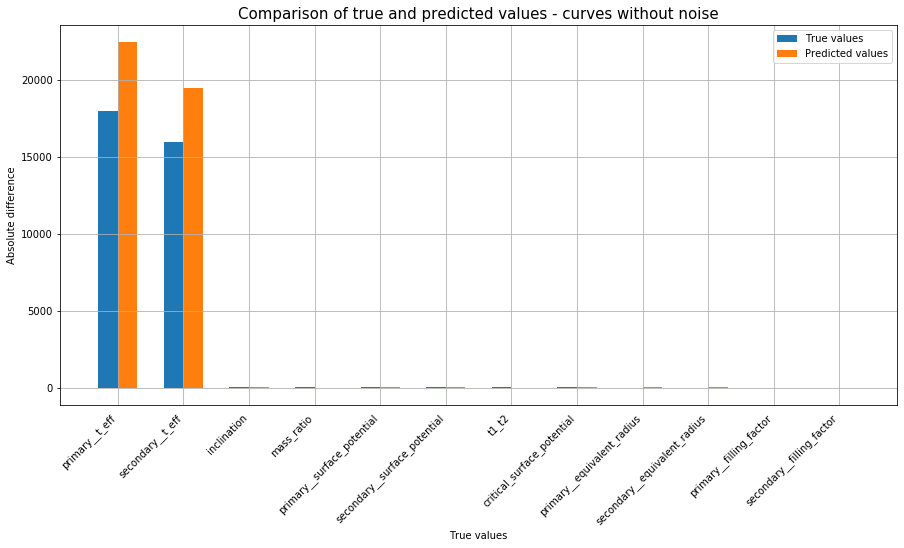

In [36]:
fig, ax = plt.subplots(figsize=(15,7))
x = np.arange(len(comp))
width = 0.3
plt.bar(x-0.15, comp.true_values, width, label='True values')
plt.bar(x+0.15, comp.predicted_values, width, label='Predicted values')
plt.title('Comparison of true and predicted values - curves without noise', fontsize=15)
plt.xticks(x, cols, rotation=45, ha='right')
ax.set_ylabel("Absolute difference")
ax.set_xlabel("True values")
ax.grid(False)
ax.tick_params(bottom=False, left=True)
plt.legend()
plt.grid(b="on")
plt.show()

### Prediction on synthetic data - with noise

In [37]:
y_pred_n=model.predict(X_test_n)

In [38]:
P_prim__t_eff = [i[0] for i in y_pred]
P_sec__t_eff = [i[1] for i in y_pred]
P_inclination = [i[2] for i in y_pred]
P_mass_ratio = [i[3] for i in y_pred]
P_prim__surface_potential = [i[4] for i in y_pred]
P_sec__surface_potential = [i[5] for i in y_pred]
P_t1_t2 = [i[6] for i in y_pred]
P_critical_surface_potential = [i[7] for i in y_pred]
P_primary_equivalent_radius = [i[8] for i in y_pred]
P_secondary_equivalent_radius = [i[9] for i in y_pred]
P_primary_filling_factor = [i[10] for i in y_pred]
P_secondary_filling_factor = [i[11] for i in y_pred]

In [39]:
P_prim__t_eff = np.reshape(P_prim__t_eff, len(P_prim__t_eff))
P_sec__t_eff = np.reshape(P_sec__t_eff, len(P_sec__t_eff))
P_inclination = np.reshape(P_inclination, len(P_inclination))
P_mass_ratio = np.reshape(P_mass_ratio, len(P_mass_ratio))
P_prim__surface_potential = np.reshape(P_prim__surface_potential, len(P_prim__surface_potential))
P_sec__surface_potential = np.reshape(P_sec__surface_potential, len(P_sec__surface_potential))
P_t1_t2 = np.reshape(P_t1_t2, len(P_t1_t2))
P_critical_surface_potential = np.reshape(P_critical_surface_potential, len(P_critical_surface_potential))
P_primary_equivalent_radius = np.reshape(P_primary_equivalent_radius, len(P_primary_equivalent_radius))
P_secondary_equivalent_radius = np.reshape(P_secondary_equivalent_radius, len(P_secondary_equivalent_radius))
P_primary_filling_factor = np.reshape(P_primary_filling_factor, len(P_primary_filling_factor))
P_secondary_filling_factor = np.reshape(P_secondary_filling_factor, len(P_secondary_filling_factor))


In [40]:
df = pd.DataFrame(data =
    {'primary__t_eff': [i[0] for i in y_test],
    'P_prim__t_eff': P_prim__t_eff,
    'prim_t_eff_abs_diff': abs([i[0] for i in y_test] - P_prim__t_eff),

    'secondary__t_eff': [i[1] for i in y_test],
    'P_sec__t_eff': P_sec__t_eff,
    'sec_t_eff_abs_diff': abs([i[1] for i in y_test] - P_sec__t_eff),

    'inclination': [i[2] for i in y_test],
    'P_inclination': P_inclination,
    'inclination_abs_diff': abs([i[2] for i in y_test] - P_inclination),

    'mass_ratio': [i[3] for i in y_test],
    'P_mass_ratio': P_mass_ratio,
    'mass_ratio_abs_diff': abs([i[3] for i in y_test] - P_mass_ratio),

    'prim_surface_potential': [i[4] for i in y_test],
    'P_prim_surf_potential': P_prim__surface_potential,
    'prim_surf_potent_abs_diff': abs([i[4] for i in y_test] - P_prim__surface_potential),

    'sec_surface_potential': [i[5] for i in y_test],
    'P_sec_surf_potential': P_sec__surface_potential,
    'sec_surf_potent_abs_diff': abs([i[5] for i in y_test] - P_sec__surface_potential),

    't1_t2': [i[6] for i in y_test],
    'P_t1_t2': P_t1_t2,
    't1_t2_abs_diff': abs([i[6] for i in y_test] - P_t1_t2),

    'critical_surf_potential': [i[7] for i in y_test],
    'P_crit_surf_potential': P_critical_surface_potential,
    'crit_surf_potential_abs_diff': abs([i[7] for i in y_test] - P_critical_surface_potential),

    'prim_equi_radius': [i[8] for i in y_test],
    'P_prim_equi_radius': P_primary_equivalent_radius,
    'prim_equi_radius_abs_diff': abs([i[8] for i in y_test] - P_primary_equivalent_radius),

    'sec_equi_radius': [i[9] for i in y_test],
    'P_sec_equi_radius': P_secondary_equivalent_radius,
    'sec_equi_radius_abs_diff': abs([i[9] for i in y_test] - P_secondary_equivalent_radius),

    'prim_filling_factor': [i[10] for i in y_test],
    'P_prim_filling_factor': P_primary_filling_factor,
    'prim_filling_factor_abs_diff': abs([i[10] for i in y_test] - P_primary_filling_factor),

    'sec_filling_factor': [i[11] for i in y_test],
    'P_sec_filling_factor': P_secondary_filling_factor,
    'sec_filling_factor_abs_diff': abs([i[11] for i in y_test] - P_secondary_filling_factor)
    })


In [41]:
df.head()

,primary__t_eff,P_prim__t_eff,prim_t_eff_abs_diff,secondary__t_eff,P_sec__t_eff,sec_t_eff_abs_diff,inclination,P_inclination,inclination_abs_diff,mass_ratio,...,prim_equi_radius_abs_diff,sec_equi_radius,P_sec_equi_radius,sec_equi_radius_abs_diff,prim_filling_factor,P_prim_filling_factor,prim_filling_factor_abs_diff,sec_filling_factor,P_sec_filling_factor,sec_filling_factor_abs_diff
0,35000.0,19656.443359,15343.556641,30000.0,16867.443359,13132.556641,1.397338,6.954834,5.557496,2.5,...,9.644014,0.249770,-0.185091,0.434862,-12.574528,-12.411372,0.163156,-7.187790,-30.553291,23.365501
1,6000.0,18484.564453,12484.564453,5000.0,9629.831055,4629.831055,1.334076,-4.218515,5.552591,10.0,...,2.304704,0.209660,-8.467279,8.676940,-22.832011,-55.720345,32.888333,-44.789259,-60.597660,15.808401
2,18000.0,20939.048828,2939.048828,10000.0,12059.776367,2059.776367,1.456709,6.069878,4.613169,0.9,...,1.636685,0.210329,-8.616093,8.826421,-0.809594,-20.931000,20.121406,-3.558689,-26.569340,23.010651
3,35000.0,25007.390625,9992.609375,10000.0,9381.316406,618.683594,1.437048,-1.111388,2.548436,0.8,...,7.916186,0.250978,-10.118877,10.369855,-0.353527,0.720583,1.074110,-2.019105,-18.171232,16.152127
4,35000.0,26804.011719,8195.988281,8000.0,7380.653320,619.346680,1.415526,-5.648054,7.063580,1.0,...,4.653741,0.089977,-3.578832,3.668809,-9.114192,-7.730265,1.383927,-15.399719,-13.489876,1.909843


In [42]:
df.to_csv('all_params_predictions/DetachedNoiseSynthetic_allParams_OneModel.csv', index=False)

In [43]:
df_copy = df.copy()
df_comp = df_copy.drop(['prim_t_eff_abs_diff',
        'sec_t_eff_abs_diff',
        'inclination_abs_diff',
        'mass_ratio_abs_diff',
        'prim_surf_potent_abs_diff',
        'sec_surf_potent_abs_diff',
        't1_t2_abs_diff',
        'crit_surf_potential_abs_diff',
        'prim_equi_radius_abs_diff',
        'sec_equi_radius_abs_diff',
        'prim_filling_factor_abs_diff',
        'sec_filling_factor_abs_diff'
        ], axis = 1)
df_comp.head()

,primary__t_eff,P_prim__t_eff,secondary__t_eff,P_sec__t_eff,inclination,P_inclination,mass_ratio,P_mass_ratio,prim_surface_potential,P_prim_surf_potential,...,critical_surf_potential,P_crit_surf_potential,prim_equi_radius,P_prim_equi_radius,sec_equi_radius,P_sec_equi_radius,prim_filling_factor,P_prim_filling_factor,sec_filling_factor,P_sec_filling_factor
0,35000.0,19656.443359,30000.0,16867.443359,1.397338,6.954834,2.5,-0.129823,13.615222,24.199518,...,5.945240,5.135097,0.090010,9.734024,0.249770,-0.185091,-12.574528,-12.411372,-7.187790,-30.553291
1,6000.0,18484.564453,5000.0,9629.831055,1.334076,-4.218515,10.0,4.880774,30.001273,37.867504,...,15.091040,2.507267,0.050001,2.354705,0.209660,-8.467279,-22.832011,-55.720345,-44.789259,-60.597660
2,18000.0,20939.048828,10000.0,12059.776367,1.456709,6.069878,0.9,3.161625,3.988424,2.384473,...,3.585603,12.207451,0.331957,-1.304728,0.210329,-8.616093,-0.809594,-20.931000,-3.558689,-26.569340
3,35000.0,25007.390625,10000.0,9381.316406,1.437048,-1.111388,0.8,1.869806,3.576202,-8.070884,...,3.416971,20.447332,0.372872,-7.543314,0.250978,-10.118877,-0.353527,0.720583,-2.019105,-18.171232
4,35000.0,26804.011719,8000.0,7380.653320,1.415526,-5.648054,1.0,4.203784,8.700863,19.517271,...,3.750000,3.655258,0.129998,-4.523743,0.089977,-3.578832,-9.114192,-7.730265,-15.399719,-13.489876


In [44]:
cols = [
    "primary__t_eff",
    "secondary__t_eff",
    "inclination",
    "mass_ratio",
    "primary__surface_potential",
    "secondary__surface_potential",
    "t1_t2",
    "critical_surface_potential",
    "primary__equivalent_radius",
    "secondary__equivalent_radius",
    "primary__filling_factor",
    "secondary__filling_factor"]

In [45]:
idx = np.random.choice(np.arange(len(y_test)), 1, replace=False)
true_sample = y_test[idx]
pred_sample = y_pred[idx]

In [46]:
comp = pd.DataFrame(data={"true_values": true_sample.flatten(),
                        "predicted_values": pred_sample.flatten()})
comp

,true_values,predicted_values
0,20000.000000,18979.529297
1,16000.000000,13681.761719
2,1.183098,7.868685
3,10.000000,1.508219
4,17.701814,18.474304
5,15.699587,7.456577
6,1.250000,0.125812
7,15.091040,-0.368298
8,0.130946,13.034304
9,0.556847,3.940059


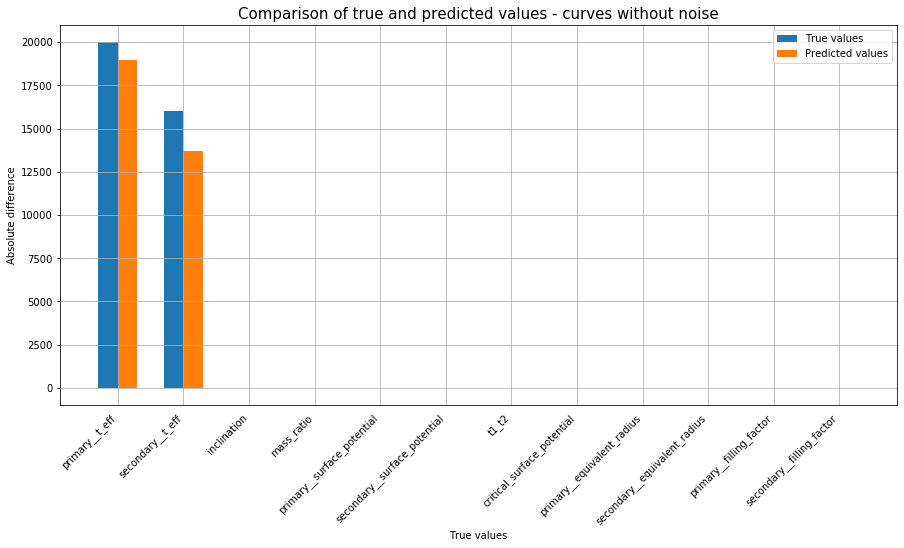

In [50]:
fig, ax = plt.subplots(figsize=(15,7))
x = np.arange(len(comp))
width = 0.3
plt.bar(x-0.15, comp.true_values, width, label='True values')
plt.bar(x+0.15, comp.predicted_values, width, label='Predicted values')
plt.title('Comparison of true and predicted values - curves without noise', fontsize=15)
plt.xticks(x, cols, rotation=45, ha='right')
ax.set_ylabel("Absolute difference")
ax.set_xlabel("True values")
ax.grid(False)
ax.tick_params(bottom=False, left=True)
plt.legend()
plt.grid(b="on")
plt.show()